In [18]:
import numpy as np
import torch
from torch import nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt

In [19]:
def logits_to_probs(logits):
    return torch.exp(logits - torch.logsumexp(logits, dim=-1, keepdim=True))

class IOHMM_model:
    def __init__(self, num_states, inputs, outputs, max_iter, tol,
                 initial_pi=None, theta_transition=None, theta_emission=None, sd=None):
    
        self.num_states = num_states
        self.inputs = inputs
        self.outputs = outputs
        self.T = inputs.shape[0]
        self.max_iter = max_iter
        self.tol = tol
        self.history = []

        # Initialize parameters
        self.initial_pi = torch.ones(num_states) / num_states if initial_pi is None else initial_pi
        self.theta_transition = torch.randn(num_states, num_states, inputs.shape[1] + 1) if theta_transition is None else theta_transition
        self.theta_emission = torch.randn(num_states, inputs.shape[1] + 1) if theta_emission is None else theta_emission
        self.sd = torch.ones(num_states, self.T) if sd is None else sd
        #self.theta_transition = pyro.param('theta_transition', torch.randn(num_states, num_states, inputs.shape[1] + 1))
        #self.theta_emission = pyro.param('theta_emission', torch.randn(num_states, inputs.shape[1] + 1))
        #self.sd = pyro.param('sd', torch.ones(num_states, self.T), constraint=dist.constraints.positive)
        #self.initial_pi = pyro.param('initial_pi', torch.ones(num_states) / num_states, constraint=dist.constraints.simplex)


    def model(self, inputs, outputs):
        
        # Initial state distribution
        z = pyro.sample('z_0', dist.Categorical(probs=self.initial_pi))

        for t in range(self.T):
            # Emission model
            emission_mean = torch.matmul(self.theta_emission[z], torch.cat((torch.ones(1), inputs[t, :])).unsqueeze(-1)).squeeze()
            sd = self.sd[z,t].exp()
            pyro.sample(f'obs_{t}', dist.Normal(emission_mean, sd), obs=outputs[t])

            if t < self.T - 1:
                # Transition model
                logits = torch.matmul(self.theta_transition[z], torch.cat((torch.ones(1), inputs[t, :])).unsqueeze(-1)).squeeze()
                transition_probs = logits_to_probs(logits)
                z = pyro.sample(f'z_{t+1}', dist.Categorical(probs=transition_probs))

    def guide(self, inputs, outputs):
        # Variational parameters for the initial state distribution
        q_initial_pi = pyro.param('q_initial_pi', self.initial_pi, constraint=dist.constraints.simplex)
        q_z = pyro.sample('z_0', dist.Categorical(probs=q_initial_pi))

        q_theta_transition = pyro.param('q_theta_transition', self.theta_transition)
        q_theta_emission = pyro.param('q_theta_emission', self.theta_emission)
        q_sd = pyro.param('q_sd', self.sd, constraint=dist.constraints.positive)


        for t in range(self.T - 1):
            logits = torch.matmul(q_theta_transition[q_z], torch.cat((torch.ones(1), inputs[t, :])))
            transition_probs = logits_to_probs(logits)
            q_z = pyro.sample(f'z_{t+1}', dist.Categorical(probs=transition_probs))

    def fit(self):
        optimizer = Adam({"lr": 0.01})
        svi = SVI(self.model, self.guide, optimizer, loss=Trace_ELBO())

        for step in range(self.max_iter):
            loss = svi.step(self.inputs, self.outputs)
            
            self.initial_pi = pyro.param('q_initial_pi')
            self.theta_emission = pyro.param('q_theta_emission')
            self.theta_transition = pyro.param('q_theta_transition')
            self.sd = pyro.param('q_sd')

            self.history.append(loss)
            if step % 10 == 0:
                print(f"Step {step}: loss = {loss}")
            if step > 0 and abs(self.history[-1] - self.history[-2]) < self.tol:
                break

In [20]:
x=np.arange(np.pi/2 , 11*np.pi/2, 0.1)
x=np.sin(x)
x_shift = x[:-1]
x = x[1:]
diff = x - x_shift

hidden_states = [0 if diff[i] > 0 else 1 for i in range(len(diff))]
y = [x[i] + np.random.normal(0.5,0.1) if hidden_states[i]==0 else x[i] - np.random.normal(0.5,0.1) for i in range(len(x))]

input = torch.tensor(np.array([x, diff]), dtype=torch.float32).T
output = torch.tensor(y, dtype=torch.float32) 

In [21]:
num_states = 2
max_iter = 100
tol = 1e-4

iohmm = IOHMM_model(num_states, input, output, max_iter, tol)
print("theta_transition")
print(iohmm.theta_transition)
print("theta_emission")
print(iohmm.theta_emission)
print("initial_pi")
print(iohmm.initial_pi)
#print(iohmm.sd)

theta_transition
tensor([[[-1.6018, -0.4087, -0.2512],
         [ 0.7785, -0.2581, -1.9196]],

        [[ 1.8021,  0.8438,  1.6848],
         [-0.2177,  0.4126,  0.3597]]])
theta_emission
tensor([[-0.6570, -1.1272,  1.3226],
        [ 1.6669, -0.3687, -0.4963]])
initial_pi
tensor([0.5000, 0.5000])


In [22]:
print(iohmm.theta_emission.shape)
print(iohmm.inputs.shape)

torch.Size([2, 3])
torch.Size([157, 2])


In [23]:
iohmm.fit()

Step 0: loss = 516.8114584796131
Step 10: loss = 148.99794578552246
Step 20: loss = 149.31365782022476
Step 30: loss = 149.02009469270706
Step 40: loss = 148.85608476400375
Step 50: loss = 148.9616652727127
Step 60: loss = 148.95769107341766
Step 70: loss = 148.92365789413452
Step 80: loss = 148.83714193105698
Step 90: loss = 148.73222917318344


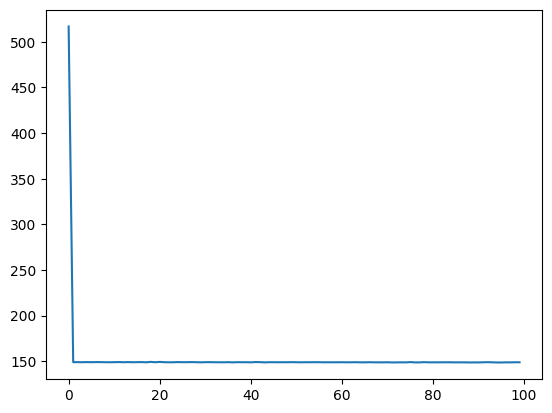

In [24]:
plt.plot(iohmm.history)

In [25]:
# inspecting the learned parameters
print("theta_transition")
print(iohmm.theta_transition)
print("theta_emission")
print(iohmm.theta_emission)
print("initial_pi")
print(iohmm.initial_pi)
#print(iohmm.sd)

theta_transition
tensor([[[-7.3903e-01,  2.4524e-03,  1.3204e-01],
         [-8.4980e-01,  2.9715e+00, -1.3494e+00]],

        [[ 6.4803e-01, -3.8824e-01,  6.1834e-01],
         [ 1.1932e+00,  1.1425e+00, -2.6338e+00]]], requires_grad=True)
theta_emission
tensor([[1.5391e-03, 1.0041e+00, 6.3776e+00],
        [5.3172e-02, 9.2317e-01, 6.3538e+00]], requires_grad=True)
initial_pi
tensor([0.5839, 0.4161], grad_fn=<DivBackward0>)


In [26]:
q_initial_pi_value = pyro.param('q_initial_pi').detach().cpu().numpy()
print(f"Final q_initial_pi: {q_initial_pi_value}")


Final q_initial_pi: [0.5839242 0.4160758]
